In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import math


from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE

In [3]:
qwen_coder = "Qwen/Qwen2.5-Coder-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(qwen_coder)
model_coder = AutoModel.from_pretrained(qwen_coder)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
qwen_normal = "Qwen/Qwen2.5-3B-Instruct"
model_normal = AutoModel.from_pretrained(qwen_normal)

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
embedding_coder = model_coder.get_input_embeddings()
embedding_normal = model_normal.get_input_embeddings()

[]

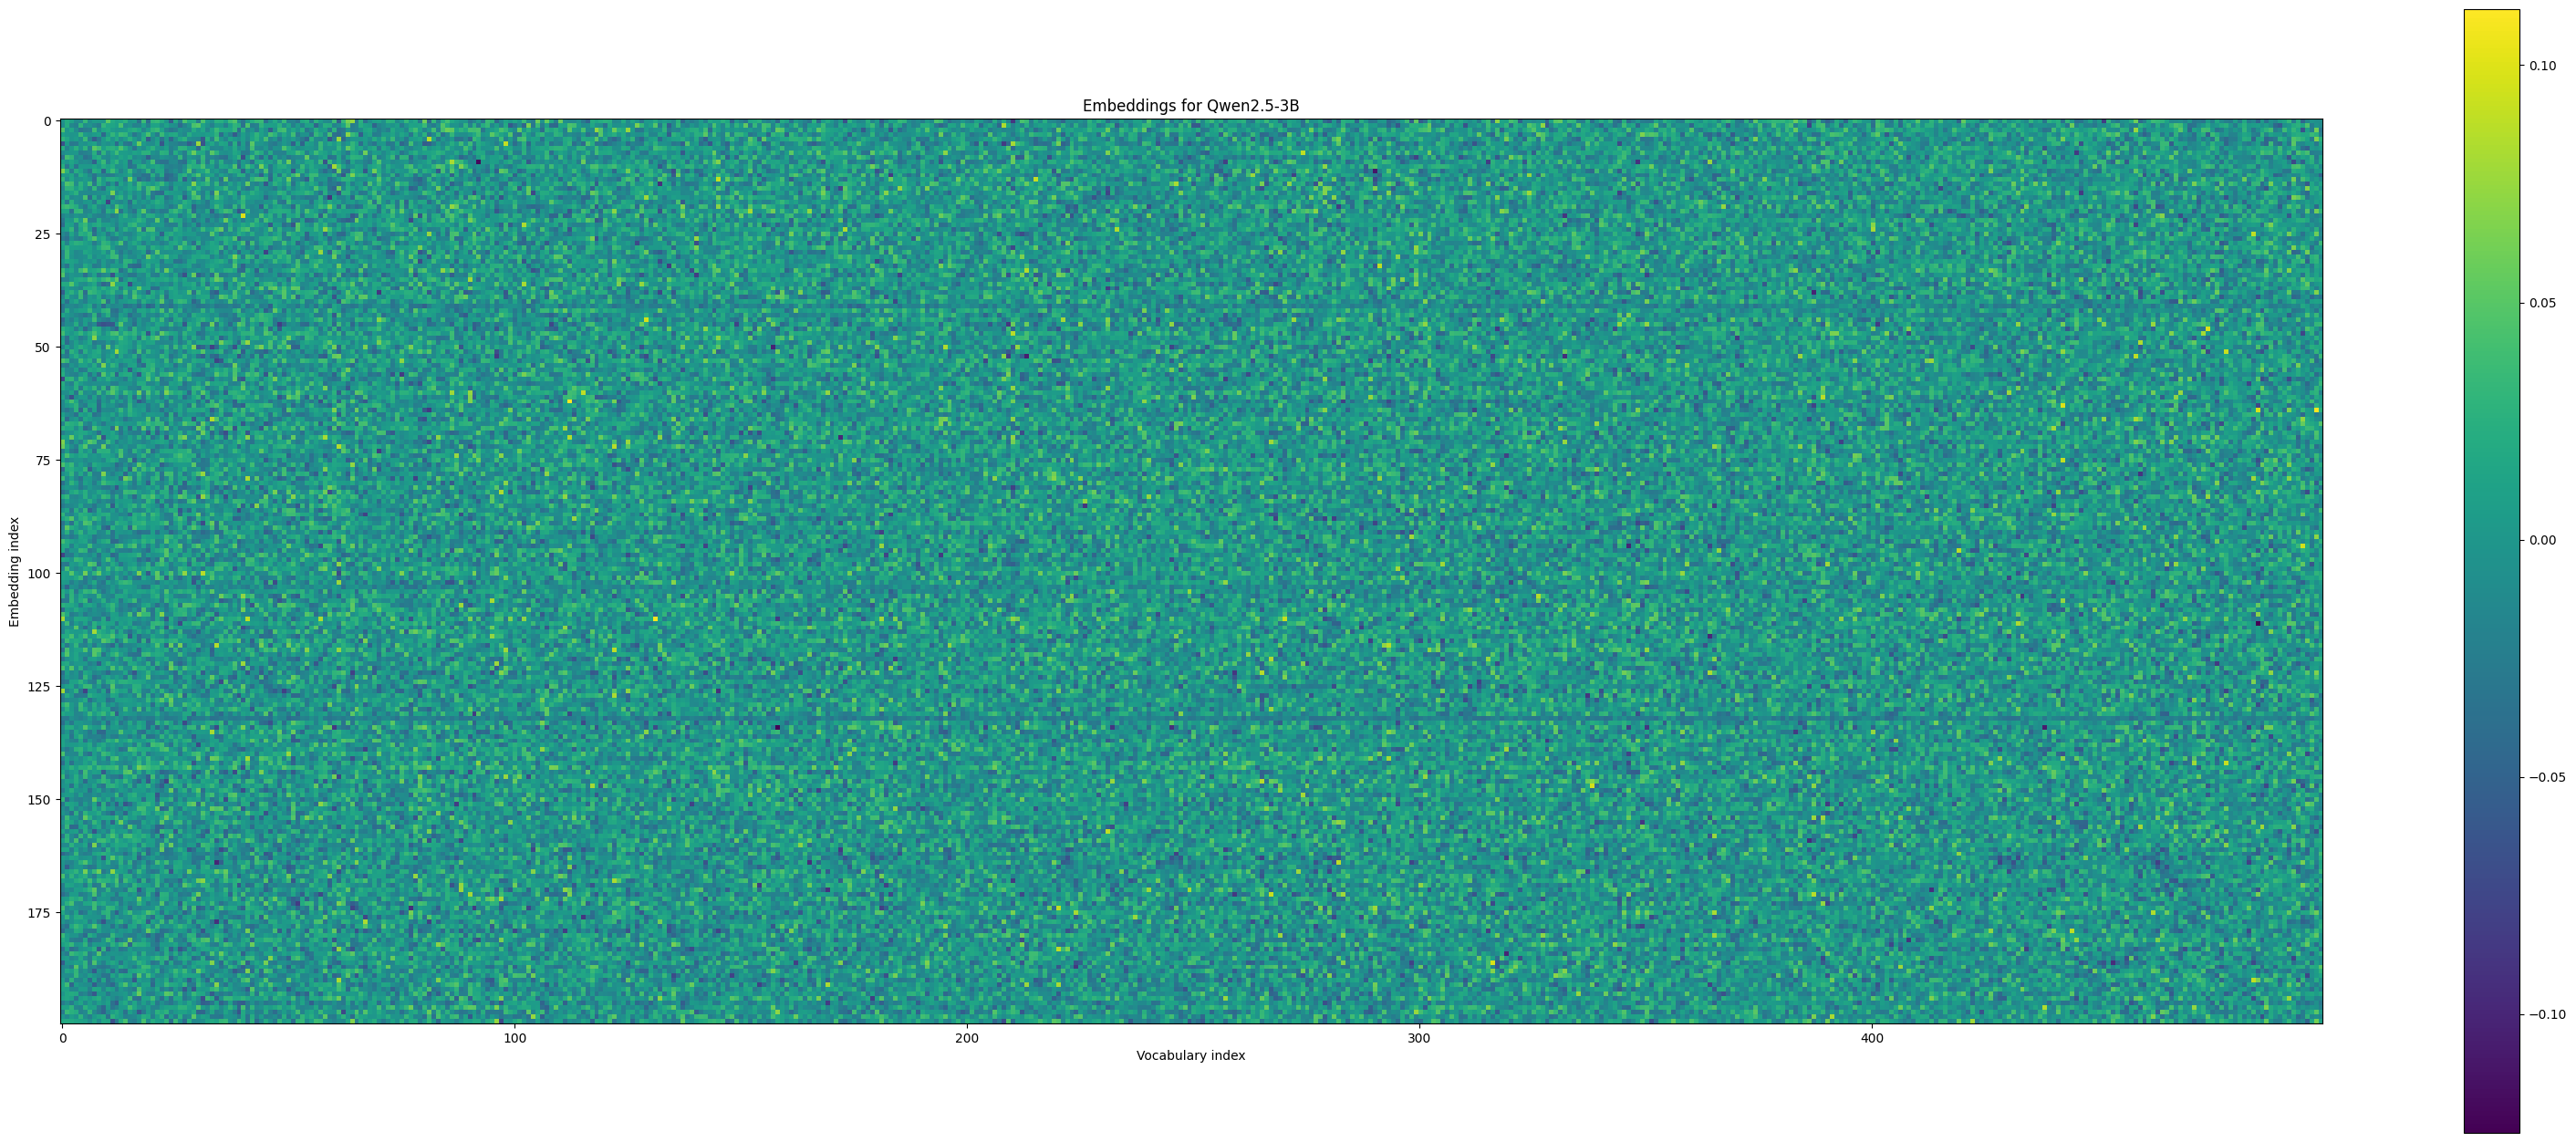

In [6]:
weights_normal = embedding_normal.state_dict()["weight"]
plt.figure(figsize=(40, 16))
im = plt.imshow(weights_normal[500:1000,:200].T)
plt.colorbar(im)
plt.title("Embeddings for Qwen2.5-3B")
plt.xlabel("Vocabulary index")
plt.ylabel("Embedding index")
plt.plot()

In [7]:
weights_normal[500:1000,:200].mean(), weights_normal[500:1000,:200].std()

(tensor(4.3649e-05), tensor(0.0249))

[]

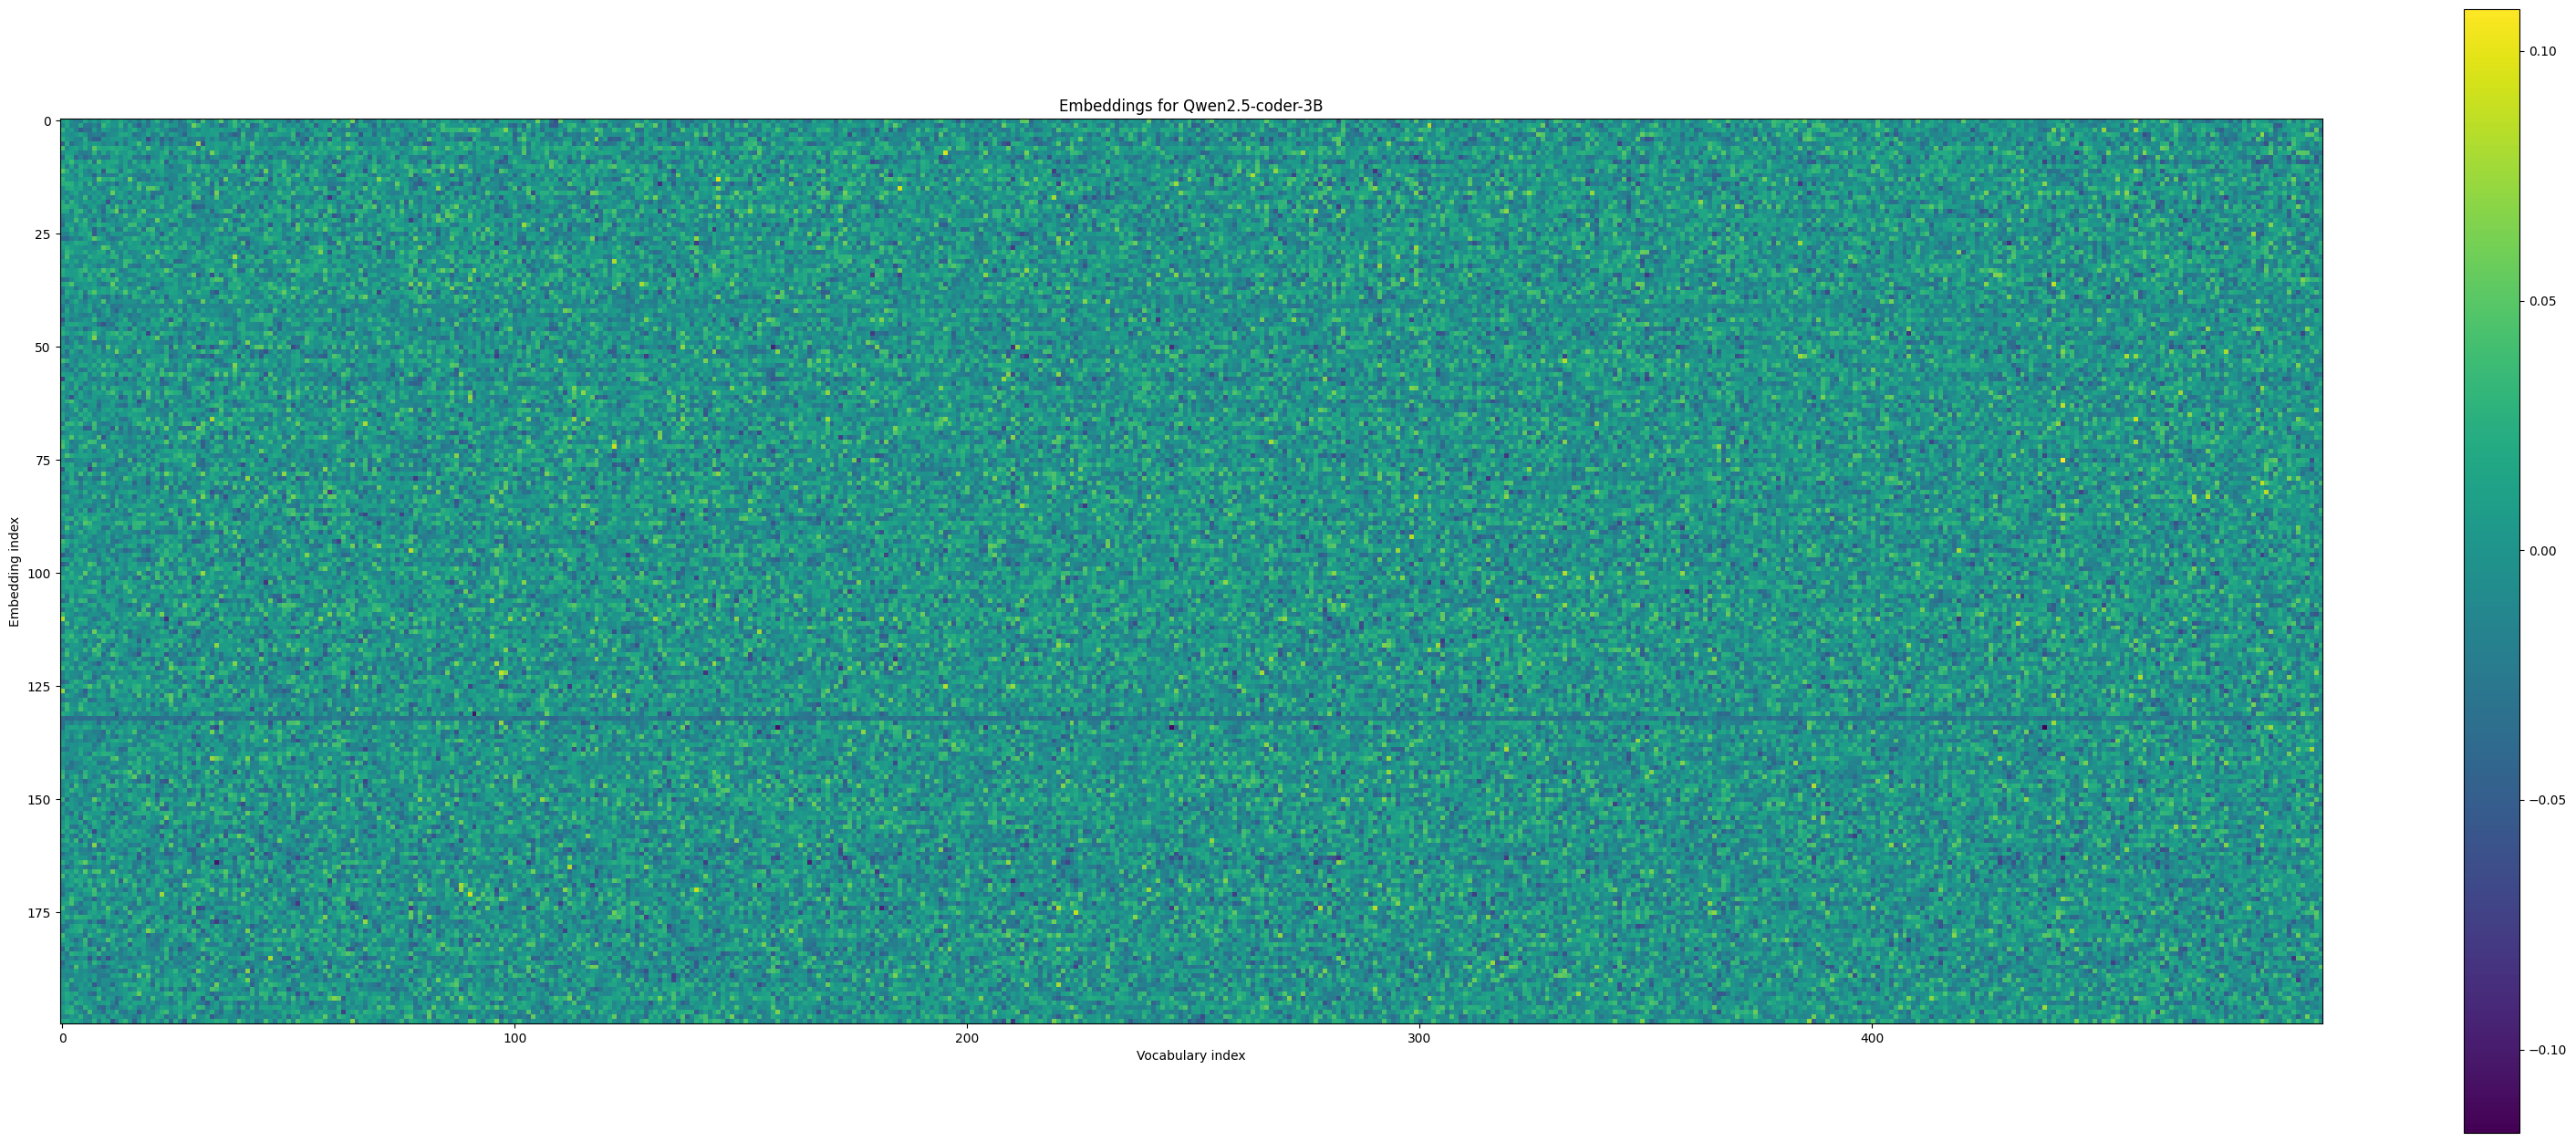

In [8]:
weights_coder = embedding_coder.state_dict()["weight"]
plt.figure(figsize=(40, 16))
im = plt.imshow(weights_coder[500:1000,:200].T)
plt.title("Embeddings for Qwen2.5-coder-3B")
plt.xlabel("Vocabulary index")
plt.ylabel("Embedding index")
plt.colorbar(im)
plt.plot()

In [9]:
weights_coder[500:1000,:200].mean(), weights_coder[500:1000,:200].std()

(tensor(-7.4978e-05), tensor(0.0225))

In [10]:
# create an animation with manim to compare some random words embeddings in 3D from the 2 models

In [11]:
df = pd.read_parquet("hf://datasets/bigcode/programming-languages-keywords/data/train-00000-of-00001-2a6aa307b284c516.parquet")
indices_to_drop = [0,1,2,5,6,7,8,9,11,12,13,14,16,18,19,20,21,24,25,26,28,34,35]
df.drop(df.index[df.index.isin(indices_to_drop)], inplace=True)

In [12]:
df

,language,keywords
3,C (C99,"[Bool, Complex, Imaginary, auto, break, case, ..."
4,C# (8.0,"[abstract, add, alias, as, ascending, async, a..."
10,C++ (C++98,"[and, asm, auto, bitand, bitor, bool, break, c..."
15,Go (1.18,"[break, case, chan, const, continue, default, ..."
17,Java (SE 17 LTS,"[abstract, assert, boolean, break, byte, case,..."
22,JavaScript (6th edition,"[await, break, case, catch, class, const, cont..."
23,Kotlin (1.4,"[abstract, actual, annotation, as, break, by, ..."
27,PHP (7.4,"[abstract, and, array, as, break, callable, ca..."
29,Python 3 (3.10,"[False, None, True, and, as, assert, async, aw..."
30,R (4.0,"[FALSE, Inf, NA, NULL, NaN, TRUE, break, chara..."


In [13]:
token_ids = set()
for l in df.iterrows():
  keywords = l[1]["keywords"]
  for keyword in keywords:
    token_id = tokenizer(keyword, add_special_tokens=False)["input_ids"]
    if len(token_id) == 1:
      token_ids.add(token_id[0])

token_ids = list(token_ids)
print(len(token_ids), token_ids)

252 [1024, 29696, 1539, 7173, 5638, 22021, 7176, 2566, 7692, 19982, 3087, 1040, 3600, 9752, 5658, 2593, 18471, 21544, 22569, 3626, 29738, 37420, 11822, 574, 32832, 3649, 28227, 25668, 1607, 1097, 8265, 63561, 43085, 10318, 22095, 3152, 2641, 4689, 83, 9309, 7265, 24674, 4197, 8808, 14956, 24175, 11887, 3699, 1653, 4214, 11894, 8822, 3194, 1149, 20611, 5764, 12935, 6280, 2186, 71311, 62095, 30351, 1688, 27289, 11421, 1694, 2207, 7326, 1700, 75940, 5286, 2215, 4776, 11944, 1192, 27307, 12458, 689, 37553, 691, 2231, 1722, 45757, 8385, 81604, 3782, 6343, 18122, 6347, 7884, 4301, 718, 1742, 23247, 721, 2258, 1235, 37588, 4310, 4825, 71900, 30940, 17119, 1762, 746, 4331, 750, 6383, 10481, 6385, 3829, 19190, 29432, 23289, 27898, 11006, 8960, 4352, 258, 10498, 93958, 263, 39176, 3849, 30473, 16135, 38157, 269, 2830, 18704, 7951, 3346, 275, 61711, 88342, 5399, 2327, 4888, 2330, 285, 4382, 1313, 10530, 52521, 810, 300, 22831, 44848, 9522, 98611, 2870, 9018, 12092, 9534, 3902, 16192, 831, 3391, 3

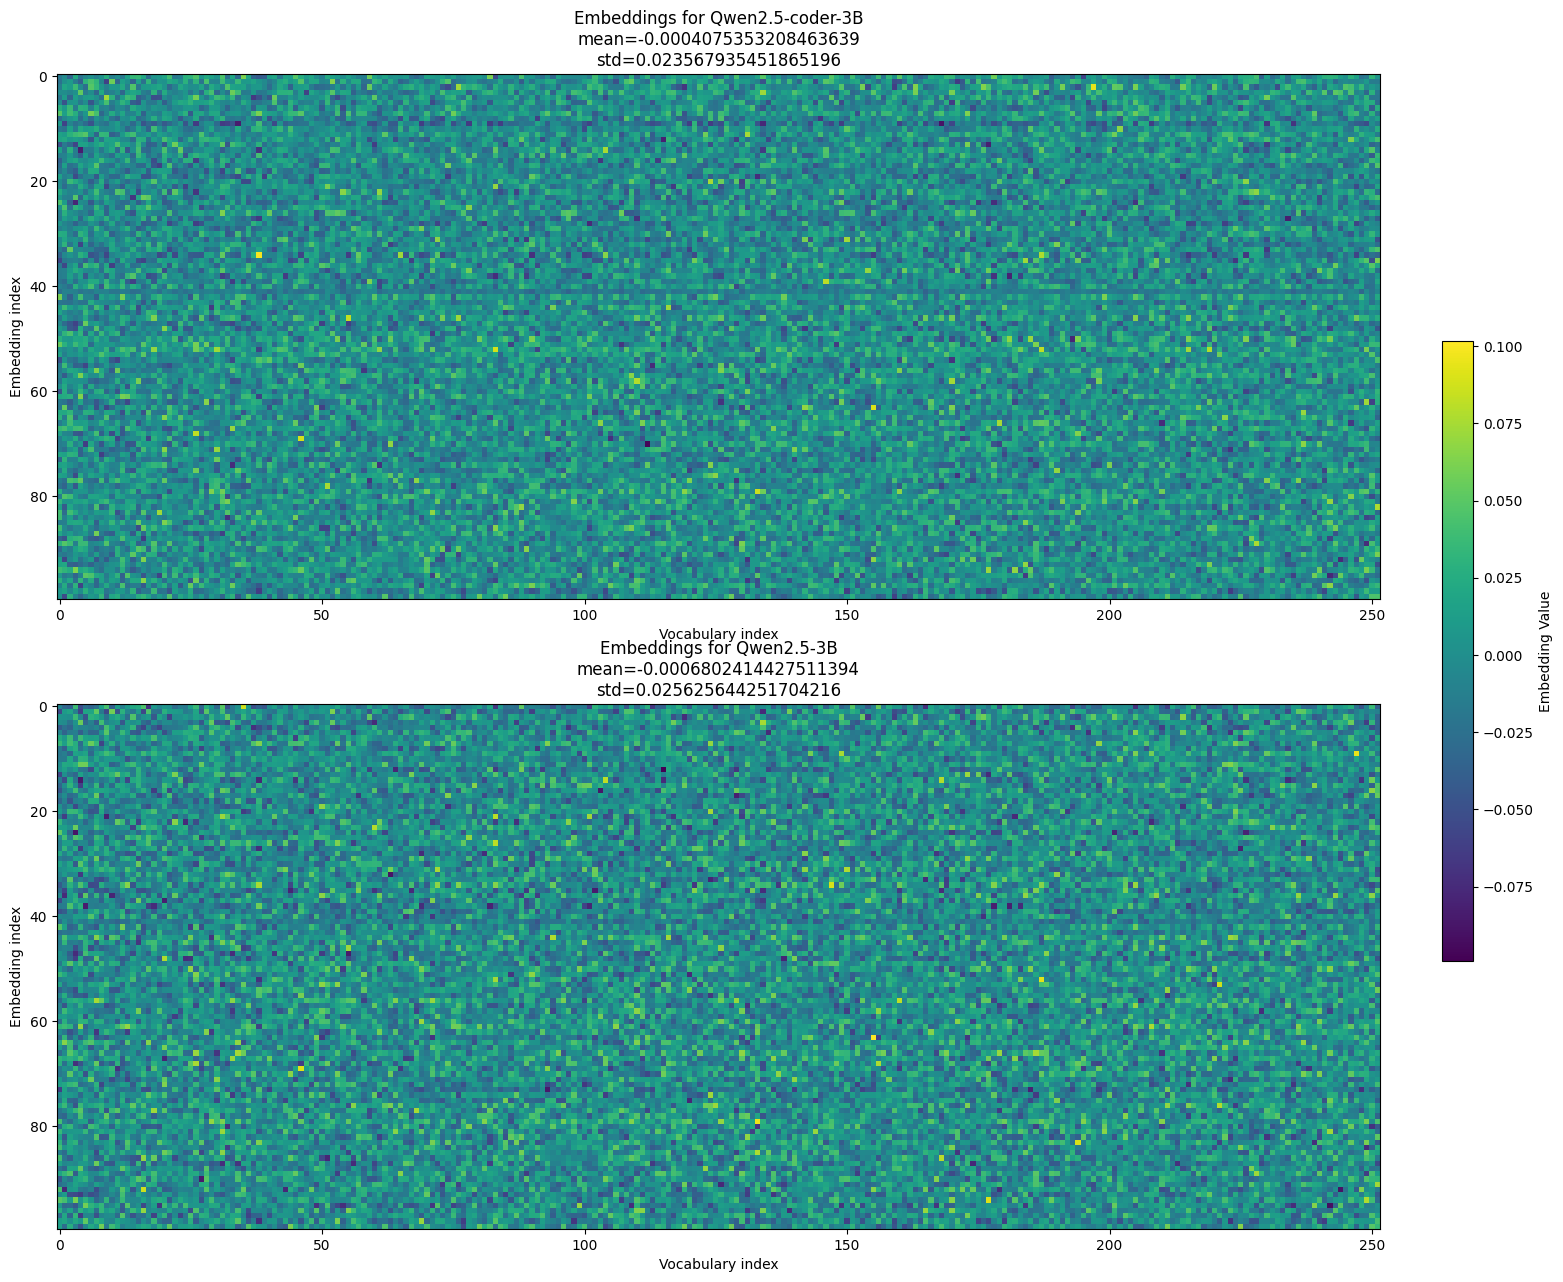

In [14]:
special_weights_coder = weights_coder[token_ids, :100].T
special_weights_normal = weights_normal[token_ids, :100].T

vmin = min(special_weights_coder.min(), special_weights_normal.min())
vmax = max(special_weights_coder.max(), special_weights_normal.max())

fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2, 1, 1)
im1 = ax1.imshow(special_weights_coder, vmin=vmin, vmax=vmax)
ax1.set_title(f"Embeddings for Qwen2.5-coder-3B\nmean={special_weights_coder.mean()}\nstd={special_weights_coder.std()}")
ax1.set_xlabel("Vocabulary index")
ax1.set_ylabel("Embedding index")

ax2 = fig.add_subplot(2, 1, 2)
im2 = ax2.imshow(special_weights_normal, vmin=vmin, vmax=vmax)
ax2.set_title(f"Embeddings for Qwen2.5-3B\nmean={special_weights_normal.mean()}\nstd={special_weights_normal.std()}")
ax2.set_xlabel("Vocabulary index")
ax2.set_ylabel("Embedding index")

cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Embedding Value')

plt.show()

We observe 2 rows on the qwen-coder embeddings matrix, which looks like 2 dimensions are here to design that these are code keywords.

In [42]:
special_weights_coder[41,:].mean(), special_weights_coder[41,:].std()

(tensor(-0.0163), tensor(0.0074))

In [43]:
special_weights_coder[10,:].mean(), special_weights_coder[10,:].std()

(tensor(-0.0007), tensor(0.0192))

In [15]:
variables = [
    # General-Purpose Variable Names
    "x", "y", "z", "i", "j", "k", "temp", "val", "result", "data", "item",
    
    # Strings
    "s", "str", "text",
    
    # Collections
    "lst", "list", "dict", "set", "arr", "queue", "stack",
    
    # Flags and Booleans
    "flag", "is_valid", "done", "found",
    
    # Counters and Indices
    "count", "index", "idx",
    
    # Mathematical Variables
    "num", "sum", "avg", "max_val", "min_val",
    
    # Iterables and Iterators
    "element", "row", "col", "key", "value", "line",
    
    # Dates and Times
    "date", "time", "timestamp",
    
    # File Handling
    "file", "filename", "f",
    
    # Machine Learning / Data Science
    "X", "y", "df", "model", "predictions",
    
    # Specific Contexts
    "user", "msg", "error",
    
    # Constants
    "PI", "E", "G",
    
    # Functions
    "func", "callback"
]

token_ids_variables = set()
for keyword in variables:
    token_id = tokenizer(keyword, add_special_tokens=False)["input_ids"]
    if len(token_id) == 1:
        token_ids_variables.add(token_id[0])
        
token_ids_variables = list(token_ids_variables)

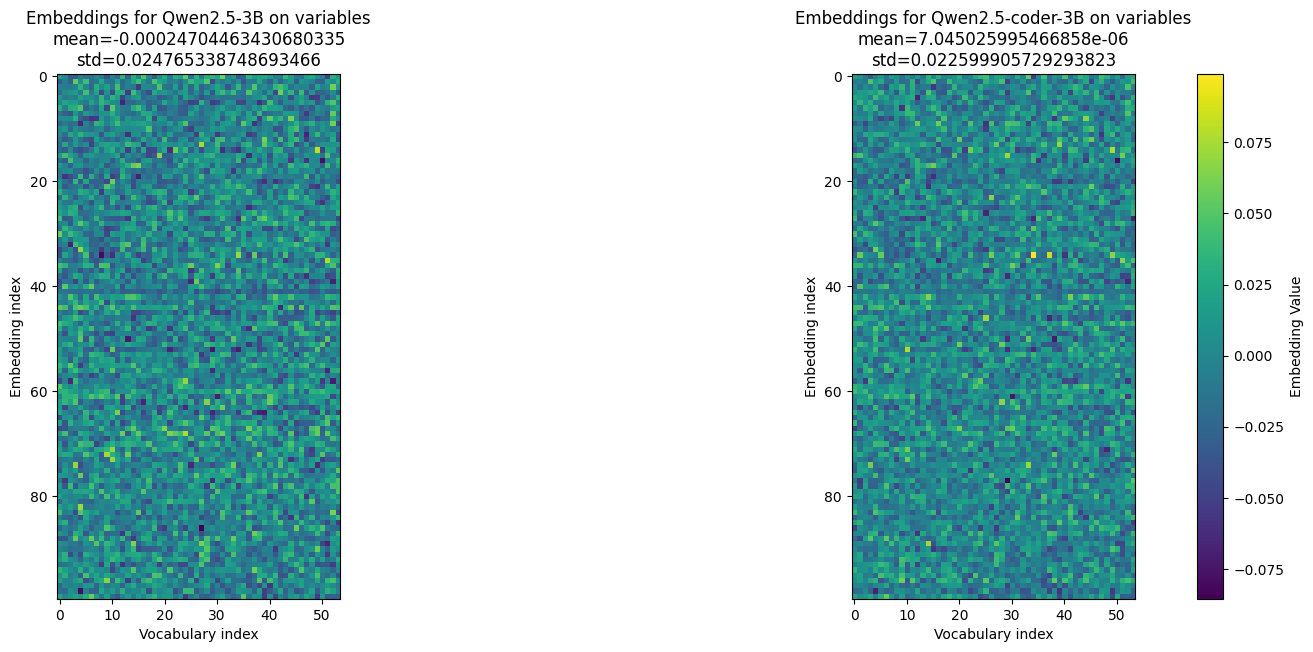

In [16]:
variables_weights_coder = weights_coder[token_ids_variables, :100].T
variables_weights_normal = weights_normal[token_ids_variables, :100].T

vmin = min(variables_weights_coder.min(), variables_weights_normal.min())
vmax = max(variables_weights_coder.max(), variables_weights_normal.max())

fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2, 1, 1)
im1 = ax1.imshow(variables_weights_coder, vmin=vmin, vmax=vmax)
ax1.set_title(f"Embeddings for Qwen2.5-coder-3B on variables\nmean={variables_weights_coder.mean()}\nstd={variables_weights_coder.std()}")
ax1.set_xlabel("Vocabulary index")
ax1.set_ylabel("Embedding index")

ax2 = fig.add_subplot(2, 2, 1)
im2 = ax2.imshow(variables_weights_normal, vmin=vmin, vmax=vmax)
ax2.set_title(f"Embeddings for Qwen2.5-3B on variables\nmean={variables_weights_normal.mean()}\nstd={variables_weights_normal.std()}")
ax2.set_xlabel("Vocabulary index")
ax2.set_ylabel("Embedding index")

cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Embedding Value')

plt.show()

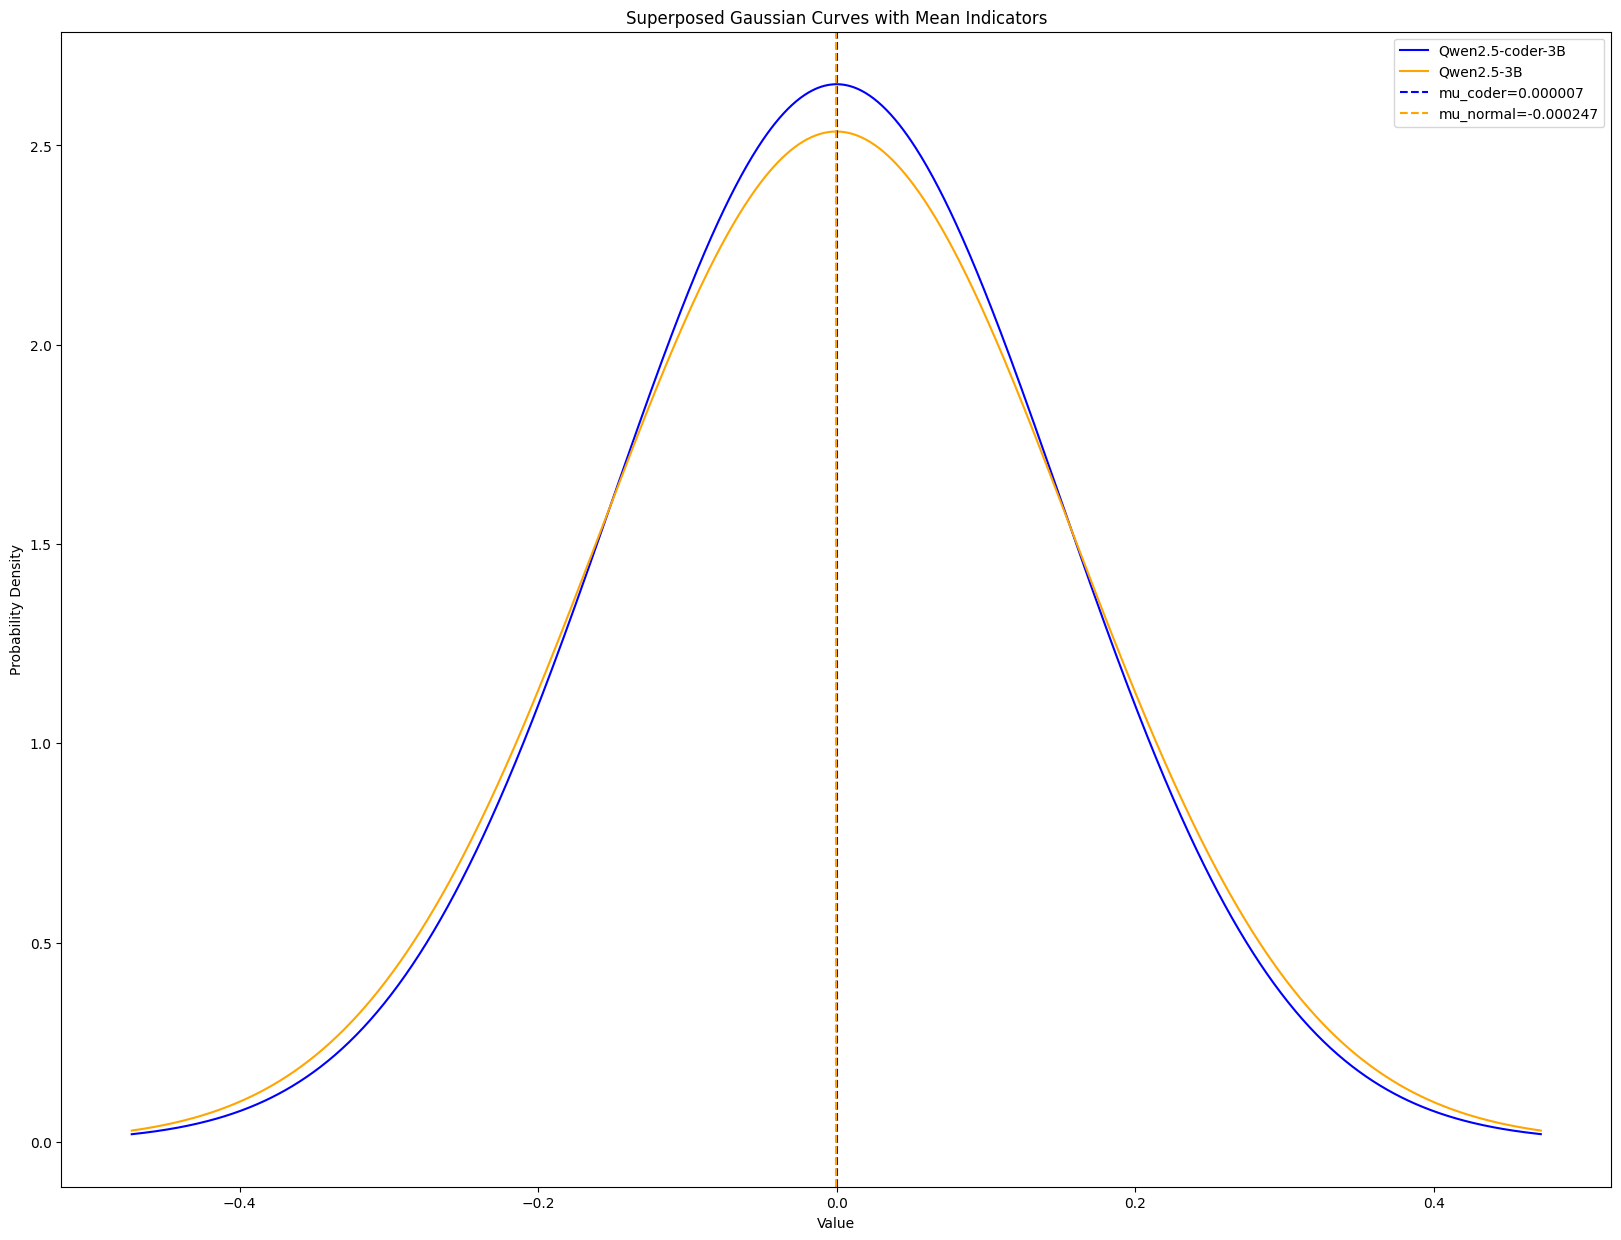

In [17]:
mu_coder = variables_weights_coder.mean().item()
variance_coder = variables_weights_coder.std().item()
sigma_coder = math.sqrt(variance_coder)

mu_normal = variables_weights_normal.mean().item()
variance_normal = variables_weights_normal.std().item()
sigma_normal = math.sqrt(variance_normal)

# Create the figure
fig = plt.figure(figsize=(20, 15))

# Single subplot for superimposed Gaussian curves
ax = fig.add_subplot(1, 1, 1)

# Define a common x-range that spans both distributions
x_min = min(mu_coder - 3 * sigma_coder, mu_normal - 3 * sigma_normal)
x_max = max(mu_coder + 3 * sigma_coder, mu_normal + 3 * sigma_normal)
x = np.linspace(x_min, x_max, 1000)

# Plot both Gaussian curves
ax.plot(x, stats.norm.pdf(x, mu_coder, sigma_coder), label="Qwen2.5-coder-3B", color="blue")
ax.plot(x, stats.norm.pdf(x, mu_normal, sigma_normal), label="Qwen2.5-3B", color="orange")

# Add vertical lines for means
ax.axvline(mu_coder, color="blue", linestyle="--", label=f"mu_coder={mu_coder:.6f}")
ax.axvline(mu_normal, color="orange", linestyle="--", label=f"mu_normal={mu_normal:.6f}")

# Add titles and labels
ax.set_title("Superposed Gaussian Curves with Mean Indicators")
ax.set_xlabel("Value")
ax.set_ylabel("Probability Density")
ax.legend()

# Show the plot
plt.show()


In [58]:
variables_weights_coder.shape

torch.Size([100, 54])

In [59]:
variables_weights_coder[41, :].mean(), variables_weights_normal[41, :].mean()

(tensor(-0.0154), tensor(-0.0241))

In [60]:
variables_weights_coder[41, :].std(), variables_weights_normal[41, :].std()

(tensor(0.0064), tensor(0.0114))

In [56]:
weights_coder[token_ids_variables][41].mean(), weights_normal[token_ids_variables].mean()

(tensor(0.0003), tensor(0.0002))

In [57]:
weights_coder[token_ids_variables].std(), weights_normal[token_ids_variables].std()

(tensor(0.0230), tensor(0.0254))

In [ ]:
# kmeans on embeddings ?

In [ ]:
words = ["quick", "fast", "slow", "happy", "joyful", "sad", "run", "jog", "walk"]

tokens = []
valid_words = []
for word in words:
    token_ids = tokenizer(word, add_special_tokens=False)["input_ids"]
    if len(token_ids) == 1:
        tokens.append(token_ids[0])
        valid_words.append(word)

tokens = torch.tensor(tokens)

# Get Embeddings for the Selected Tokens
with torch.no_grad():
    embeddings = embedding_layer(tokens).cpu().numpy()

# Dimensionality Reduction using t-SNE
tsne = TSNE(n_components=3, random_state=42, perplexity=5)
reduced_embeddings = tsne.fit_transform(embeddings)